In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import mode
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
from sklearn.dummy import DummyClassifier
import folium

Eu não consegui subir o arquivo traffic_data.feather para o github. Para que o código funcione faça o download em:
https://drive.google.com/file/d/1-ZaBayjQxlq07Xgs1PosZZMBga4nvBB0/view?usp=sharing 

In [2]:
path = "data/traffic_data.feather"

#reading dataframe
df = pd.read_feather(path)
df.drop(['index'],axis=1,inplace=True)

In [3]:
#checking columns with null data
df.isnull().sum()

passage            0
direction          0
type         3323735
region       2509341
timestamp          0
jam_size           0
segment            0
dtype: int64

In [4]:
#null data pie chart
def pie_plot(column):
  data = pd.DataFrame({
      'value': ['not null data','null data'],
      'sum': [column.count(),column.isna().sum()]})

  sum = data['sum'].groupby(data['value']).sum()
  plt.title(column.name)
  plt.pie(sum, labels=sum.index,autopct= lambda p: '{:.2f}%'.format(p))
  plt.show()

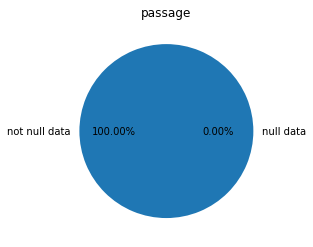

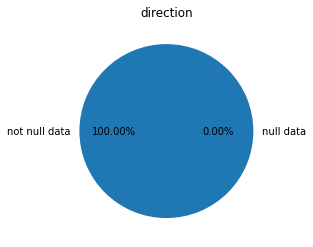

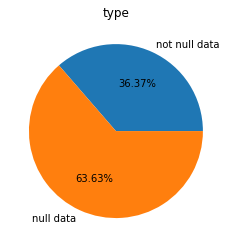

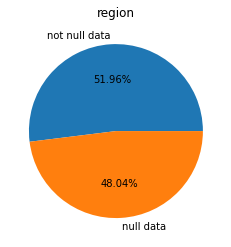

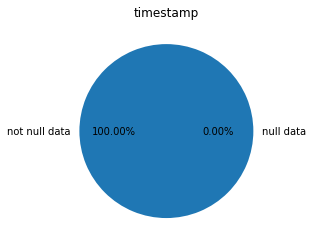

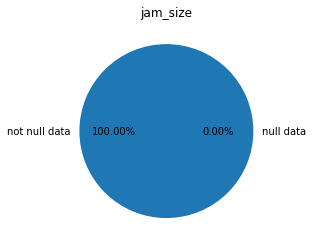

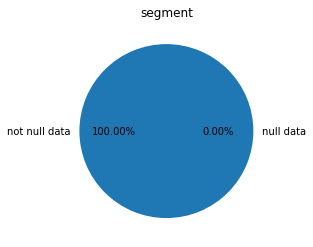

In [5]:
#ploting graphs
for column in df:
  pie_plot(df[column])

In [6]:
#creating year,month,day_of_week and hour columns
df['year'] = pd.DatetimeIndex(df['timestamp']).year
df['month'] = pd.DatetimeIndex(df['timestamp']).month
df['day_of_week'] = pd.DatetimeIndex(df['timestamp']).weekday
df['hour'] = pd.DatetimeIndex(df['timestamp']).hour

In [7]:
#converting datetime data to discrete data
df['timestamp'] = pd.to_numeric(df['timestamp'])

In [8]:
#replacing categorical data with frequency, transforming into discrete data
#using frequency as numeric data makes you prioritize recurring data in 
#predictive analytics
df['passage'] = pd.to_numeric(df.groupby('passage')['passage']
                              .transform('count'))
df['direction'] = pd.to_numeric(df.groupby('direction')['direction']
                                .transform('count'))
df['region'] = pd.to_numeric(df.groupby('region')['region']
                             .transform('count'))
df['type'] = pd.to_numeric(df.groupby('type')['type']
                           .transform('count'))   
df['segment'] = pd.to_numeric(df.groupby('segment')['segment']
                              .transform('count')) 

In [9]:
#for categorical data I use the most frequent value to replace the missing 
#ones,but, even converting to discrete data, I keep the same reasoning
df['type'].fillna(mode(df['type']).mode[0], inplace = True)
df['region'].fillna(mode(df['region']).mode[0], inplace = True)

region = pd.DataFrame(df['region']) #this will be used after to make a map

In [10]:
#scatter plot by year,month,day_of_week and hour
months = {
  1:'January',
  2:'February',
  3:'March',
  4:'April',
  5:'May',
  6:'June',
  7:'July',
  8:'August',
  9:'September',
  10:'October',
  11:'November',
  12:'December' 
}

days_of_week = {
  0:'Monday',
  1:'Tuesday',
  2:'Wednesday',
  3:'Thursday',
  4:'Friday',
  5:'Saturday',
  6:'Sunday'
}

def scatter_plot(column):
  x = pd.unique(column)
  freq = pd.to_numeric(df.groupby(column.name)[column.name]
                              .transform('count'))
  y = pd.unique(freq)

  if column.name == 'month':
      x = list(map(lambda object: months[object],x))
  elif column.name == 'day_of_week':
      x = list(map(lambda object: days_of_week[object],x))
  

  plt.ylabel('traffic jams')
  plt.xlabel(column.name)
  plt.plot(x,y,'o')
  plt.show()

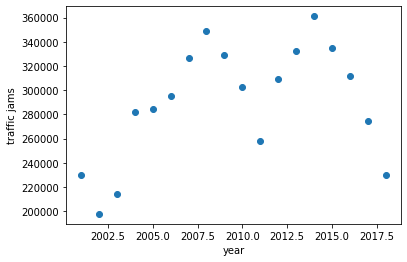

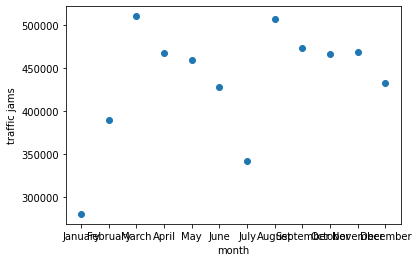

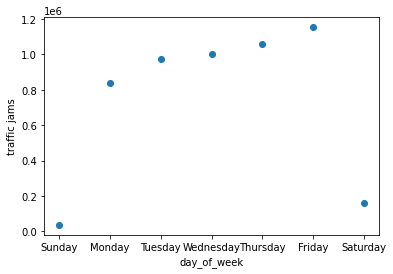

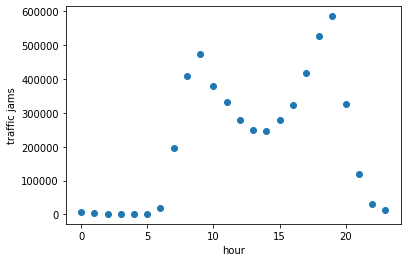

In [11]:
#ploting graphs
scatter_plot(df['year'])
scatter_plot(df['month'])
scatter_plot(df['day_of_week'])
scatter_plot(df['hour'])

Ao observar a passagem dos anos, pode-se perceber a tendência de diminuição dos engarrafamentos, por mais que haja dois picos. Talvez isso seja resultando do planejamento urbano de São Paulo.
Já quando se analisa a relação dos engarrafamentos e os meses do ano, percebe-se que na alta temporada os engarrafamentos diminuem, talvez seja porque as pessoas tendem a viajar nesses meses ou ficar mais em casa.
Algo semelhante ocorre se observar a semana. No fim de semana, que é o período em que as pessoas geralmente não trabalham nem as escolas/faculdades funcionam, a quantidade de engarrafamentos é absurdamente inferior. No entanto, algo a se observar é tendência de aumento durante a semana.
Por fim, observar os engarrafamentos ao longo do dia faz que se comprove o impacto do horário comercial no trânsito. Os picos ocorrem exatamente quando as pessoas geralmente saem de casa e quando retornam.    

In [12]:
#normalizing data
df = (df - df.min()) / ( df.max() - df.min())

Não consegui resolver o problema de classificação proposto, então para mostrar meu conhecimento de classificação, montei e treinei um classificador para dizer se a via era expressa ou não.

In [13]:
#checking the correlation matrix to choose the variables
corr = df.corr()
corr.style.background_gradient(cmap='coolwarm',axis=None)

,passage,direction,type,region,timestamp,jam_size,segment,year,month,day_of_week,hour
passage,1.000000,-0.094868,-0.504574,0.001888,-0.063597,0.438540,-0.149721,-0.063536,0.000346,0.018118,-0.006097
direction,-0.094868,1.000000,0.122809,0.074646,0.014925,-0.082104,0.107404,0.015272,-0.006054,0.002021,-0.043480
type,-0.504574,0.122809,1.000000,0.042895,0.036961,-0.120056,0.106781,0.037368,-0.008124,-0.005680,0.020443
region,0.001888,0.074646,0.042895,1.000000,-0.459363,-0.021146,0.005615,-0.460338,0.030005,0.004684,0.082139
timestamp,-0.063597,0.014925,0.036961,-0.459363,1.000000,-0.009650,0.106346,0.998385,-0.000639,0.014757,-0.043058
jam_size,0.438540,-0.082104,-0.120056,-0.021146,-0.009650,1.000000,-0.181349,-0.009958,0.005572,0.024279,0.051354
segment,-0.149721,0.107404,0.106781,0.005615,0.106346,-0.181349,1.000000,0.105950,0.003797,0.006309,-0.000124
year,-0.063536,0.015272,0.037368,-0.460338,0.998385,-0.009958,0.105950,1.000000,-0.057242,0.013949,-0.044036
month,0.000346,-0.006054,-0.008124,0.030005,-0.000639,0.005572,0.003797,-0.057242,1.000000,0.013791,0.016941
day_of_week,0.018118,0.002021,-0.005680,0.004684,0.014757,0.024279,0.006309,0.013949,0.013791,1.000000,0.059063


In [14]:
#ploting correlation matrix of chosen variables
matrix = df[['type','passage', 'direction','jam_size']]
corr = matrix.corr()
corr.style.background_gradient(cmap='coolwarm',axis=None)

,type,passage,direction,jam_size
type,1.000000,-0.504574,0.122809,-0.120056
passage,-0.504574,1.000000,-0.094868,0.438540
direction,0.122809,-0.094868,1.000000,-0.082104
jam_size,-0.120056,0.438540,-0.082104,1.000000


In [15]:
#choosing the variables ​​with the largest correlation modules in relation
#to the variable type and ploting correlation graph
def corr_plot(column):
  plt.ylabel('type')
  plt.xlabel(column.name)
  plt.plot(column,df['type'],'o')
  plt.show()


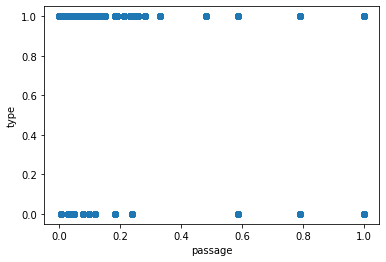

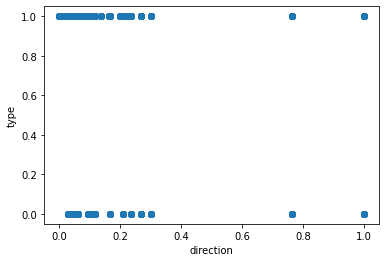

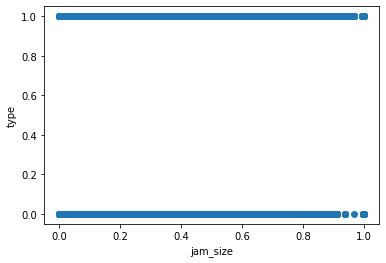

In [16]:
#ploting graphs
corr_plot(df['passage'])
corr_plot(df['direction'])
corr_plot(df['jam_size'])

In [17]:
#separating data and then splitting between training data and testing data
x = df[['passage', 'direction','jam_size']]
y = df['type']

In [18]:
#choosing the seed to decrease randomness
SEED = 5
np.random.seed(SEED)

In [19]:
#separating test data from training data
train_x, test_x, train_y, test_y = train_test_split(x, y, test_size = 0.25,
                                                    stratify = y)

In [20]:
#training
clf = DecisionTreeClassifier()
clf.fit(train_x, train_y)
prediction = clf.predict(test_x)

accuracy = accuracy_score(test_y, prediction) * 100
print("Model accuracy = %.2f%%" % accuracy)

Model accuracy = 93.86%


In [21]:
#accuracy of the base model to compare the effectiveness of the developed model
dummy_mostfrequent = DummyClassifier()
dummy_mostfrequent.fit(train_x, train_y)
accuracy_dummy = dummy_mostfrequent.score(test_x, test_y) * 100

print("Most frequent dummy model accuracy = %.2f%%" % accuracy_dummy)

/usr/local/lib/python3.7/dist-packages/sklearn/dummy.py:132: FutureWarning: The default value of strategy will change from stratified to prior in 0.24.
  "stratified to prior in 0.24.", FutureWarning)


Most frequent dummy model accuracy = 82.41%


Percebe-se que o modelo utilizado é eficiente por ser melhor que o DummyClassifier

In [22]:
#creating dataframe to make a heatmap
regions = {
  732056.0 : 'Zona Oeste, São Paulo, SP',
  621874.0 : 'Zona Sul, São Paulo, SP',
  410407.0 : 'Zona Leste, São Paulo, SP',
  811594.0 : 'Centro, São Paulo, SP',
  138176.0 : 'Zona Norte, São Paulo, SP'
}

latitude = {
  732056.0 : -23.5719,
  621874.0 : -23.6542,
  410407.0 : -23.5338,
  811594.0 : -23.5408,
  138176.0 : -23.5489
}

longitude = {
  732056.0 : -46.7008,
  621874.0 : -46.6592,
  410407.0 : -46.5033,
  811594.0 : -46.6321,
  138176.0 : -46.6388    
}

region['latitude'] = region['region'].map(latitude)
region['longitude'] = region['region'].map(longitude)
region['region'] = region['region'].map(regions)

In [28]:
from folium import plugins

#creating heat map
cordinates = []

for lat,lng in zip(region.latitude[:20000],region.longitude[:20000]):
  cordinates.append([lat,lng])

map = folium.Map(location=[-23.56992, -46.62684],zoom_start=12,tiles='Stamen Terrain')

map.add_child(plugins.HeatMap(cordinates))

Como eu não consegui trabalhar os dados para extrair as localizações que pudessem ser reconhecidas pela biblioteca geopy para ter as latitudes e longitudes, exibindo posteriormente um mapa de calor mais complexo com a biblioteca folium, utilizei apenas as regiões. Por serem apenas 5, não houve necessidade do uso da biblioteca citada.    